# Taxi Tip Prediction using Scikit-Learn and Snap ML
In this Data Science project, I will consolidate my machine learning (ML) modeling skills by using a popular regression model: Decision Tree. I will use a real dataset to train such a model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). I will use the trained model to predict the amount of tip paid. 

Here, I will practice not only the Scikit-Learn Python interface, but also the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy.

The dataset used in this exercise session is publicly available here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. The prediction of the tip amount can be modeled as a regression problem. To train the model we used part of the input dataset and the remaining data can also be used to assess the quality of the trained model.

#### Importing libraries

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
import requests
warnings.filterwarnings('ignore')

#### Lets download the dataset

In [6]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv'

In [ ]:
url = path
response = requests.get(url)

with open("yellow_tripdata_2019-06.csv", "wb") as file:
    file.write(response.content)

In [2]:
data = pd.read_csv('yellow_tripdata_2019-06.csv')

print('There are ' + str(len(data)) + ' total number of observations on the dataset')
print('There are ' + str(len(data.columns)) + ' total number of columns/variables on the dataset')
data.head()

There are 3936004 total number of observations on the dataset
There are 18 total number of columns/variables on the dataset


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


#### Analyzing the dataset

In [3]:
# Lets reduce the data size by 100,000 records
data = data.head(100000)

Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. Let's first clean the dataset and retrieve basic statistics about the target variable.

In [4]:
# Checking the number of N/A contained in each variable
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [5]:
# Some trips report 0 tip. It is assumed that these tips were paid in cash. For this study we drop all these rows
data = data[data['tip_amount'] > 0]

In [6]:
# We will also remove some outliers, namely those where the tip was larger than the fare cost
data = data[(data['tip_amount'] <= data['fare_amount'])]

In [7]:
# We remove trips with very large fare cost
data = data[((data['fare_amount'] >= 2) & (data['fare_amount'] <= 200))]

In [8]:
# We drop variables that include the target variable in it, namely the total_amount
clean_data = data.drop(['total_amount'], axis=1)

In [9]:
# Release memory occupied by 'data' as we do not need it anymore. We are dealing with a large dataset, thus we need to make sure we do not run out of memory
del data
gc.collect()

0

In [10]:
# Print the number of trips left in the dataset
print('The number of data in the observation of the dataset is:', str(len(clean_data)))
print('The number of variables in the dataset is:', str(len(clean_data.columns)))
clean_data.head()

The number of data in the observation of the dataset is: 65351
The number of variables in the dataset is: 17


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


Minimum value is: 0.01
Maximum value is: 60.09
90th percentile: 5.15


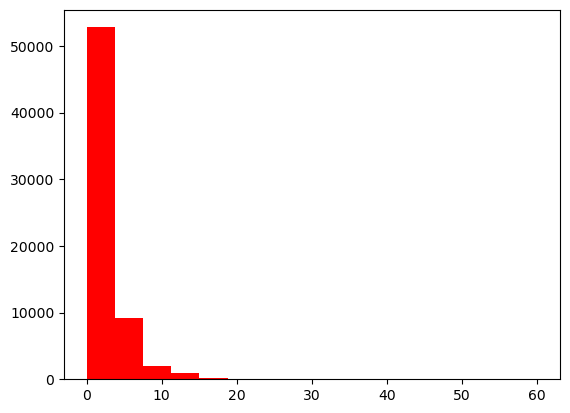

In [11]:
# Plot the histogram of the target variable tip_amount
print('Minimum value is:', np.min(clean_data['tip_amount']))
print('Maximum value is:', np.max(clean_data['tip_amount']))
print('90th percentile:', np.percentile(clean_data['tip_amount'], 90))

plt.hist(clean_data['tip_amount'], 16, histtype='bar', color='r')
plt.show()

In [12]:
# Display first rows in the dataset
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.

#### Preprocessing of Dataset

In [13]:
# Changing the date format
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])

In [14]:
# Extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

In [15]:
# Extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

In [16]:
# Compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

In [17]:
# Ideally use the full dataset for this exercise. However, if we run into out of memory issues due to the data size, it is adviseable to reduce it. For instance, we use only the first 1M samples
clean_data = clean_data.head(1000000)

In [18]:
# Drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [19]:
# Some features are categorical, we need to encode them and to encode them we use one-hot encoding from the Pandas package
get_dummy_column = ["VendorID", "RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID", "payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
processed_data = pd.get_dummies(clean_data, columns=get_dummy_column)

In [20]:
# Release memory occupied by clean_data as we do not need it anymore. We are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

4160

In [22]:
# Extract the labels or targeted variable from the dataframe
y = processed_data[['tip_amount']].values.astype('float32')
y

array([[2.65],
       [1.  ],
       [1.  ],
       ...,
       [4.56],
       [2.06],
       [1.  ]], dtype=float32)

In [23]:
# Drop the target variable from the feature matrix
processed_data = processed_data.drop(['tip_amount'], axis=1)
X = processed_data.values

In [25]:
# Normalize the feature matrix X
X = normalize(X, axis=1, norm='l1', copy=False)

In [26]:
# Lets print the shape of the features matrix X and the labels vector y
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (65351, 461)
y.shape: (65351, 1)


#### Dataset Train/Test Split
Now that the dataset is ready for building the classification models, we need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (45745, 461) (45745, 1)
Testing set: (19606, 461) (19606, 1)


#### Decision Tree Regressor model with Scikit-Learn

In [28]:
# Import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

In [29]:
# For reproducible output across multiple function calls, we set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=28)

In [30]:
# Train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  5.55381


#### Decision Tree Regressor model with Snap ML

In [31]:
# Import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

In [34]:
# To set the number of CPU threads used at training time, one needs to set the n_jobs parameter. For reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=48, n_jobs=4)

In [35]:
# Train a Decision Tree Regressor using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  2.71237


#### Evaluating the Scikit-Learn and Snap ML Decision Tree Regressor Models

In [37]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 2.05x 


In [38]:
# Run inference using the sklearn model
sklearn_prediction = sklearn_dt.predict(X_test)

In [39]:
# Evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_prediction)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 1.879


In [40]:
# Run inference using the Snap ML model
snapml_prediction = snapml_dt.predict(X_test)

In [41]:
# Evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_prediction)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Snap ML] MSE score : 1.845


As shown above both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine faster than Scikit-Learn. This is one of the advantages of using Snap ML: acceleration of training of classical machine learning models, such as linear and tree-based models. Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.